# TASK 1

### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared
### Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline 
#импортируем библиотеки


In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
#Импортируем датасет по регистрациям

Смотрим на датасет (типы данных, пропущенные значения, повторения uid, какие даты есть в датасете)

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [5]:
reg_data.shape[0]

1000000

In [6]:
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
reg_data.uid.duplicated().sum()

0

In [8]:
pd.to_datetime(reg_data['reg_ts'], unit='s').describe(datetime_is_numeric=True)

count                          1000000
mean     2019-01-24 12:12:34.523666688
min                1998-11-18 09:43:43
25%         2018-06-03 13:55:11.500000
50%                2019-07-30 02:35:25
75%         2020-04-01 16:28:40.500000
max                2020-09-23 15:17:24
Name: reg_ts, dtype: object

In [9]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
#Импортируем датасет по авторизациям

Смотрим на датасет (типы данных, пропущенные значения, повторения uid, какие даты есть в датасете)

In [10]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [12]:
auth_data.shape[0]

9601013

In [13]:
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [14]:
auth_data.uid.nunique()

1000000

Пишем функцию для расчета Retention для пользователей


In [15]:
def retention_count (reg_data,
                     auth_data,
                     start,
                     end
                    ):
    
    """Функция retention_count() принимает на вход два датасета с данными о регистрации пользователей, данными об
авторизации пользователей и две даты в формате 'YYYY-MM-DD' -- дата начала и конца требуемых наблюдений 
(например с 2016-11-18 до 2016-12-18), на выходе даёт таблицу, где в колонках дни с момента регистрации, 
индексы -- даты регистрации, а в ячейках процент пользователей, зашедших в данный день в игру"""
    
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.round('d') 
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.round('d') # Приводим timestamp к датам
    
    reg_data = reg_data.query('reg_ts >= @start and reg_ts <= @end')
    auth_data = auth_data.query('auth_ts >= @start and auth_ts <= @end') # Отбираем значения только для заданного диапазона дат
    
    auth_data = auth_data.merge(reg_data, on='uid') # Создаём таблицу, где для каждой авторизации у пользователя будет указана его дата регистрации. 
    # Оставляем inner join на случай, если в данных будут баги и по какой-то причине пользователь 
    # не попадёт в лог регистрации или авторизации, тогда расчёт Retention будет некорректен
    
    auth_data['days_since_registration'] = (auth_data['auth_ts'] - auth_data['reg_ts']).dt.days # Создаём колонку с количеством дней с момента регистрации пользователя
    
    cohort_data = auth_data.groupby(['reg_ts', 'days_since_registration'])['uid'] \
                           .nunique().reset_index() # считаем сколько пользователей зарегистрировалось в какой день
    cohort_counts = cohort_data.pivot(index='reg_ts', 
                                      columns='days_since_registration', 
                                      values='uid') # делаем таблицу с количеством игроков в каждый день в зависимости от их даты регистрации
    registrations = cohort_counts[0] # Серия с количеством игроков, зарегистрировавшихся в каждый день из диапазона дат
    retention = cohort_counts.divide(registrations, axis=0).round(3).mul(100)
    retention = pd.DataFrame(retention)

    return retention

In [16]:
start_date = '2016-11-18'
end_date = '2016-12-18'

In [17]:
results = retention_count(reg_data, auth_data, start_date, end_date)

In [18]:
results

days_since_registration,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2016-11-18,100.0,2.5,4.9,4.9,3.7,5.5,7.4,7.4,5.5,5.5,...,3.1,4.3,4.3,3.7,1.8,4.3,5.5,3.1,4.3,3.1
2016-11-19,100.0,3.7,3.0,3.0,7.3,8.5,9.1,5.5,4.9,5.5,...,4.9,1.8,3.7,3.7,2.4,3.0,1.8,4.3,2.4,NaN
2016-11-20,100.0,1.8,5.5,4.3,5.5,4.3,6.1,6.1,3.1,7.4,...,3.1,4.9,4.3,3.1,5.5,3.1,2.5,3.1,NaN,NaN
2016-11-21,100.0,3.7,4.9,2.4,6.1,7.3,7.9,4.9,6.1,4.3,...,3.0,3.7,3.7,3.0,2.4,4.9,1.8,NaN,NaN,NaN
2016-11-22,100.0,1.2,4.3,4.3,8.5,2.4,6.1,5.5,1.8,4.3,...,3.7,1.2,1.8,1.8,1.2,3.0,NaN,NaN,NaN,NaN
2016-11-23,100.0,3.7,4.3,3.7,6.7,7.3,6.1,5.5,7.3,4.9,...,4.3,5.5,3.7,1.8,3.0,NaN,NaN,NaN,NaN,NaN
2016-11-24,100.0,1.2,2.4,4.8,3.6,4.2,4.2,3.6,2.4,3.0,...,2.4,1.8,1.8,1.8,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-25,100.0,1.2,4.8,4.2,6.1,4.2,8.5,4.8,6.7,3.6,...,2.4,5.5,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-26,100.0,1.8,6.1,4.2,4.2,4.8,7.3,3.0,1.8,3.0,...,1.2,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def retention_vis (retention_table):
    
    """Функцию для визуализации retention таблицы, которая принимает на вход retention table и выдаёт heatmap"""
    
    plt.figure(figsize=(26,20))
    sns.set(font_scale=1.5)
    plt.title('Retention Table, %')
    ax = sns.heatmap(data=retention_table, annot=True, fmt='.3g', cmap='Blues')
    ax.set_yticklabels(retention_table.reset_index().reg_ts.astype(str).str[:10]) 
    plt.show()

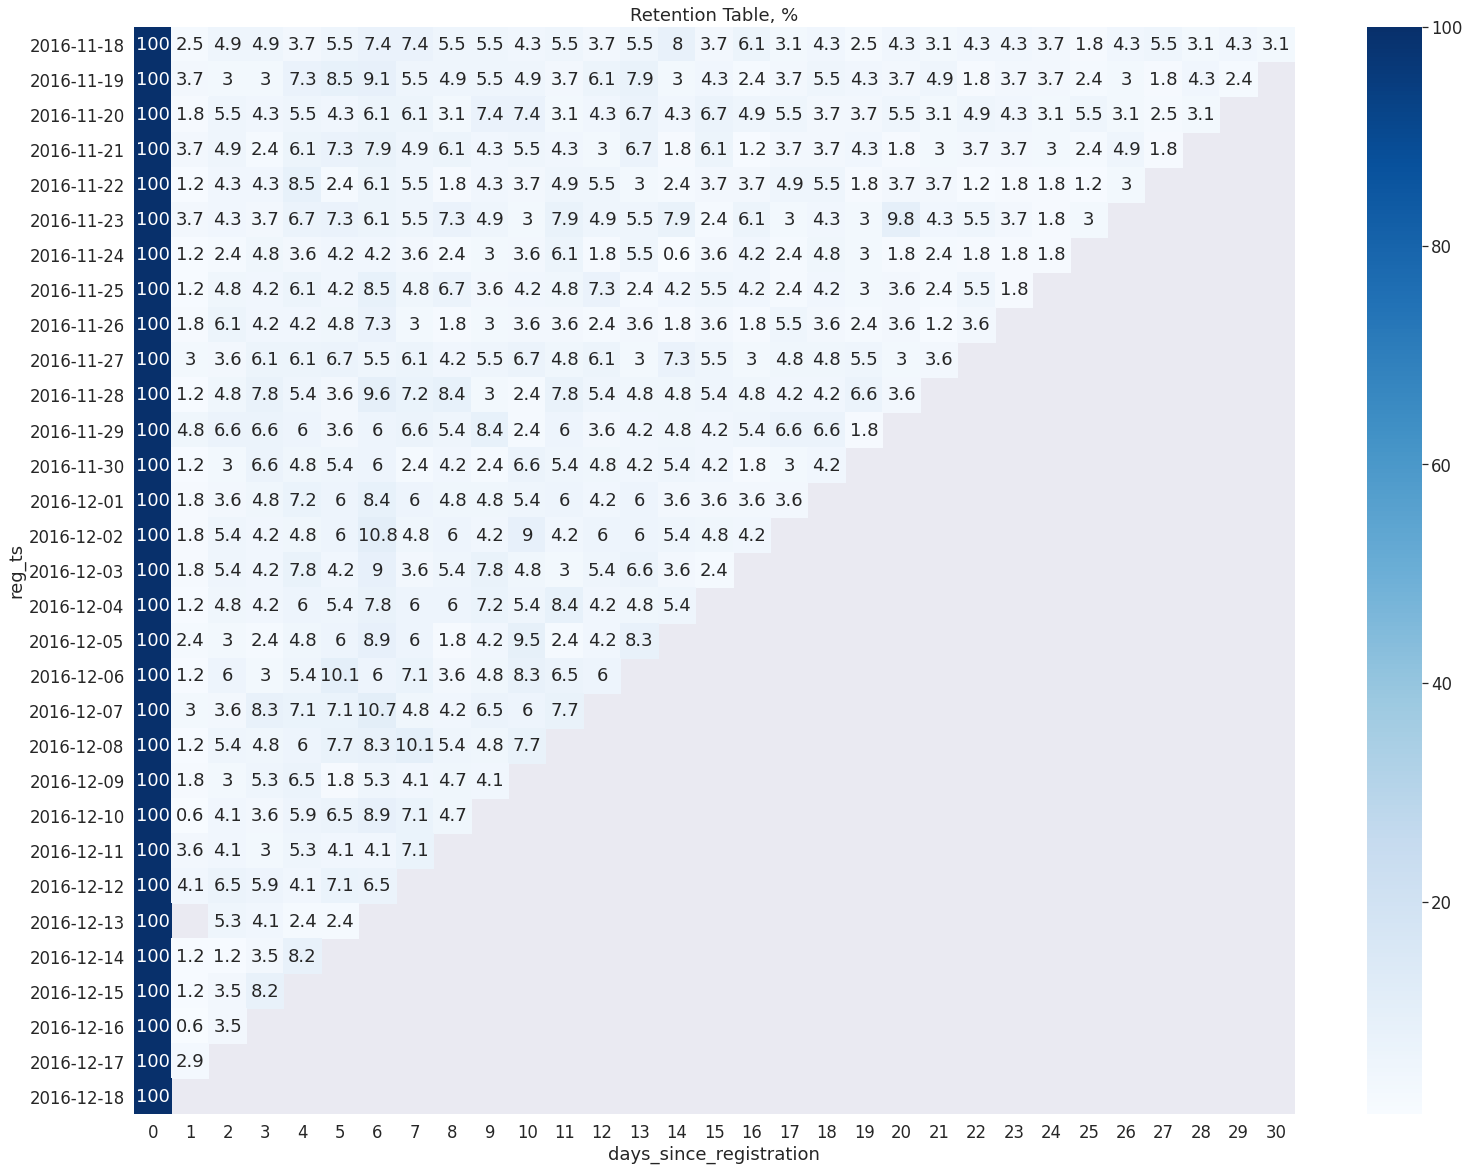

In [20]:
retention_vis(results)